In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
#! pip install langgraph-checkpoint-sqlite

In [2]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
# Create the tools
 
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the ...'}]

In [4]:
llm_with_tools = llm.bind_tools(tools)
llm= llm_with_tools

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [7]:
graph_builder = StateGraph(State)

In [8]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [9]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=[tool])

In [10]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

In [11]:
graph_builder.add_conditional_edges("chatbot",tools_condition,)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [12]:
graph = graph_builder.compile(checkpointer=memory)

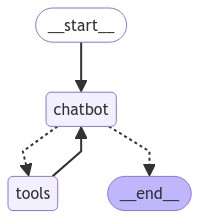

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
# Function to generate a unique thread ID
import uuid

def generate_thread_id() -> str:
    return str(uuid.uuid4())

In [15]:
thread_id_1 = generate_thread_id()

In [17]:
config_1 = {"configurable": {"thread_id": thread_id_1}}

In [18]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello, Will! How can I assist you today?


In [19]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Will! How can I help you today?


In [21]:
thread_id_2 = generate_thread_id()
config_2 = {"configurable": {"thread_id": thread_id_2}}

In [22]:
user_input = "Remember my name?"
events = graph.stream(
    {"messages": [("user", user_input)]}, config_2, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember past interactions or personal details like your name. However, you can tell me your name if you'd like!


In [23]:
user_input = "Remember my name?"
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will! How can I assist you further?
